In [21]:
%load_ext autoreload
%autoreload 2
import torch
import matplotlib.pyplot as plt

from gptopt.linalg_utils import ns_pinv, rel_err

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
A = torch.load("/mnt/home/nghosh/GPT-opt/debug_matrices/C__orig_mod.transformer.h.0.attn.c_proj.weight_step_1.pt")
G = torch.load("/mnt/home/nghosh/GPT-opt/debug_matrices/grad__orig_mod.transformer.h.0.attn.c_proj.weight_step_1.pt")

In [23]:
A

tensor([[ 3.9062e-03, -2.3804e-03,  1.4038e-03,  ..., -2.6245e-03,
         -3.3112e-03, -6.8665e-05],
        [-2.3804e-03,  7.5989e-03,  5.0735e-04,  ...,  4.9133e-03,
          6.8054e-03,  1.2436e-03],
        [ 1.4038e-03,  5.0735e-04,  3.5095e-03,  ..., -2.8992e-04,
          1.2302e-04,  2.1309e-06],
        ...,
        [-2.6245e-03,  4.9133e-03, -2.8992e-04,  ...,  6.2561e-03,
          6.3171e-03,  8.0490e-04],
        [-3.3112e-03,  6.8054e-03,  1.2302e-04,  ...,  6.3171e-03,
          1.1414e-02,  1.3580e-03],
        [-6.8665e-05,  1.2436e-03,  2.1309e-06,  ...,  8.0490e-04,
          1.3580e-03,  2.1515e-03]], device='cuda:0')

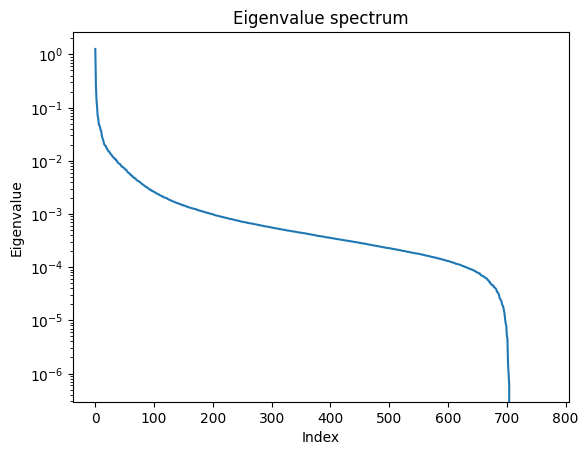

In [24]:
# Compute eigenvalues and sort in descending order
eigvals = torch.linalg.eigvalsh(A).sort(descending=True)[0]

plt.figure()
plt.plot(eigvals.cpu())
plt.title("Eigenvalue spectrum")
plt.xlabel("Index")
plt.ylabel("Eigenvalue") 
plt.yscale("log")
plt.show()


tensor(0.0041, device='cuda:0')


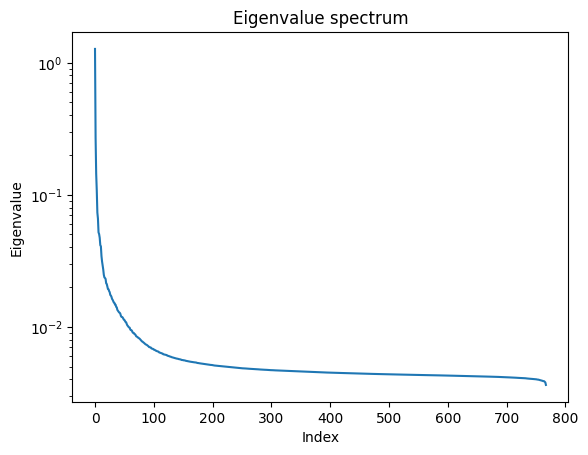

In [25]:
# Compute eigenvalues and sort in descending order
damping = 1
eff_damping = damping * torch.trace(A) / A.shape[0]
print(eff_damping)

eigvals = torch.linalg.eigvalsh(A).sort(descending=True)[0]
eigvals = eigvals + eff_damping
plt.figure()
plt.plot(eigvals.cpu())
plt.title("Eigenvalue spectrum")
plt.xlabel("Index")
plt.ylabel("Eigenvalue") 
plt.yscale("log")
plt.show()

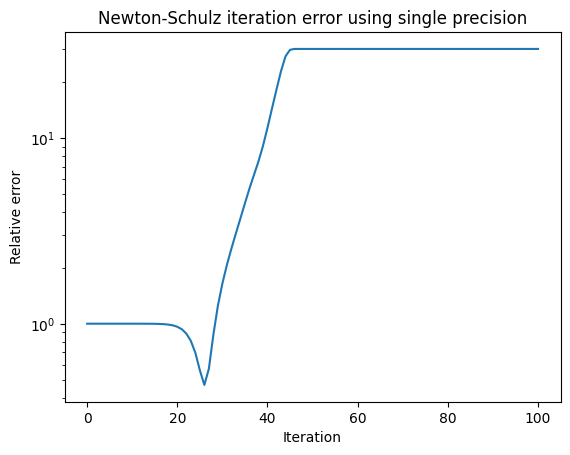

30.203886032104492
final:  30.203937530517578


In [26]:
A_pinv, A_pinv_errs = ns_pinv(A, max_steps=100, diagnostics=True, use_double=False)
plt.plot(A_pinv_errs)
plt.title("Newton-Schulz iteration error using single precision")
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.yscale("log")
plt.show()

print(A_pinv_errs[-1])
print("final: ", rel_err(A_pinv, torch.linalg.pinv(A)))

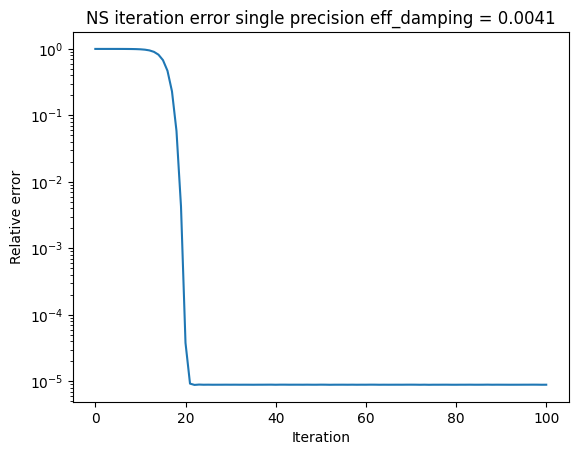

8.865677955327556e-06
final:  9.770907126949169e-06


In [28]:
damping = 1
eff_damping = damping * torch.trace(A) / A.shape[0]
A_damp = A + eff_damping * torch.eye(A.shape[0], device=A.device, dtype=A.dtype)
A_pinv, A_pinv_errs = ns_pinv(A_damp, max_steps=100, diagnostics=True, use_double=False)
plt.plot(A_pinv_errs)
plt.title(f"NS iteration error single precision eff_damping = {eff_damping:.4f}")
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.yscale("log")
plt.show()

print(A_pinv_errs[-1])
print("final: ", rel_err(A_pinv, torch.linalg.pinv(A_damp)))

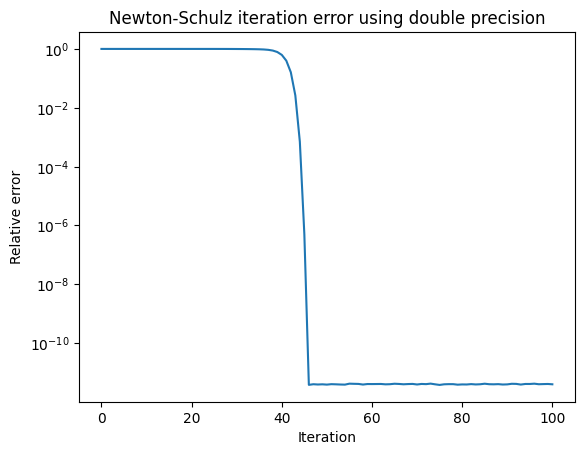

3.9788188735137935e-12
final:  2.6066601913656786e-12


In [62]:
A_pinv, A_pinv_errs = ns_pinv(A, max_steps=100, diagnostics=True, use_double=True)
plt.plot(A_pinv_errs)
plt.title("Newton-Schulz iteration error using double precision")
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.yscale("log")
plt.show()

print(A_pinv_errs[-1])
print("final: ", rel_err(A_pinv, torch.linalg.pinv(A.double())))

In [63]:
rel_err(torch.linalg.pinv(A), torch.linalg.pinv(A.double()))

0.9990919185048089

In [64]:
torch.linalg.pinv(A)

tensor([[10.2540, -1.4674, -2.0551,  ...,  0.7062,  0.1657,  1.7158],
        [-1.4674, 15.3113,  0.0829,  ..., -1.2893,  1.0779, -0.7685],
        [-2.0551,  0.0830, 15.3583,  ..., -0.4157, -1.0560, -1.2980],
        ...,
        [ 0.7063, -1.2892, -0.4157,  ..., 15.3018, -0.2009,  1.5254],
        [ 0.1658,  1.0778, -1.0559,  ..., -0.2009, 11.4422, -0.5630],
        [ 1.7157, -0.7685, -1.2979,  ...,  1.5252, -0.5629, 13.1263]],
       device='cuda:0')

In [65]:
torch.linalg.pinv(A.double())

tensor([[ 18.3130,  -5.5628,  -2.4989,  ...,   0.9987,   0.5523,  -4.0200],
        [ -5.5628,  69.0293,  19.7302,  ..., -77.3786, -49.7500,  32.6724],
        [ -2.4989,  19.7302,  36.8797,  ..., -45.2184, -27.2144,  13.2100],
        ...,
        [  0.9987, -77.3786, -45.2184,  ..., 162.2855,  84.8389, -65.6872],
        [  0.5523, -49.7500, -27.2144,  ...,  84.8389,  75.4347, -42.5118],
        [ -4.0200,  32.6724,  13.2100,  ..., -65.6872, -42.5118,  54.2135]],
       device='cuda:0', dtype=torch.float64)

In [66]:
Y = torch.linalg.lstsq(A, G.T).solution.T

In [67]:
Y

tensor([[-5.6877e-05, -9.1967e-04, -4.9601e-04,  ...,  1.5960e-03,
          9.6471e-04, -7.2574e-04],
        [-2.2881e-05,  2.7535e-04,  6.1819e-05,  ..., -4.9736e-04,
         -1.6866e-04,  3.3051e-04],
        [-2.3677e-05,  1.3115e-03,  6.5201e-04,  ..., -2.0339e-03,
         -1.4849e-03,  1.0159e-03],
        ...,
        [ 1.7366e-04, -3.9703e-03, -1.1400e-03,  ...,  5.6069e-03,
          4.1803e-03, -2.8831e-03],
        [ 6.5930e-04, -6.0297e-04, -5.5327e-04,  ...,  2.0172e-03,
          1.4889e-03, -8.1570e-04],
        [ 2.1127e-04,  9.2919e-04, -1.2312e-03,  ...,  1.3521e-03,
         -2.6889e-04, -1.5049e-03]], device='cuda:0')

In [68]:
rel_err(Y, G @ torch.linalg.pinv(A))

10.119277000427246

In [69]:
rel_err(Y, G @ ns_pinv(A, max_steps=100, diagnostics=False, use_double=False))

0.005962052848190069

In [70]:
rel_err(Y.double(), G.double() @ torch.linalg.pinv(A.double()))

0.0001818580488065598

tensor(25987.7207, device='cuda:0')


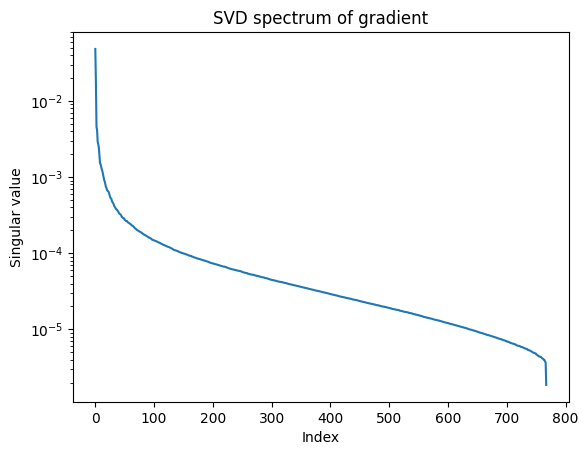

In [84]:
# Compute eigenvalues and sort in descending order
svals = torch.linalg.svdvals(G)
print(svals[0] / svals[-1])

plt.figure()
plt.plot(svals.cpu())
plt.title("SVD spectrum of gradient")
plt.xlabel("Index")
plt.ylabel("Singular value") 
plt.yscale("log")
plt.show()

tensor(539353.5000, device='cuda:0')


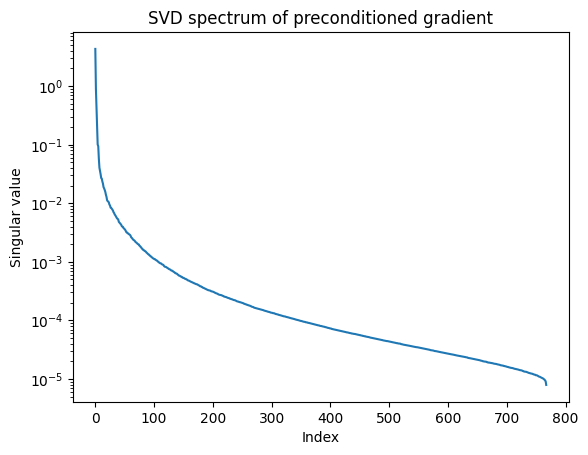

In [83]:
# Compute eigenvalues and sort in descending order
svals = torch.linalg.svdvals(Y)

print(svals[0] / svals[-1])

plt.figure()
plt.plot(svals.cpu())
plt.title("SVD spectrum of preconditioned gradient")
plt.xlabel("Index")
plt.ylabel("Singular value") 
plt.yscale("log")
plt.show()

print()